In [1]:
from stochastic_volatility_models.src.models.time_series.realised_garch import ReGARCH
from stochastic_volatility_models.src.core.underlying import Underlying
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-08-24 20:53:47.551 | INFO     | stochastic_volatility_models.config:initialise:30 - Loaded module `stochastic_volatility_models` from project directory path `/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules`


In [2]:
regarch = ReGARCH()

In [3]:
# TODO: Test with much later data
time = np.datetime64("2016-02-02")
underlying = Underlying("SPX")
regarch.fit(time=time, underlying=underlying)

forecast_period = 1
regarch.forecast(forecast_period=forecast_period)

probs = [0.6, 0.75, 0.95, 0.99]
regarch.quantiles(probs=probs)

array([[0.00324964, 0.00302481, 0.00285413, ..., 0.00204239, 0.00204239,
        0.00204239],
       [0.00351589, 0.00338013, 0.00325665, ..., 0.00244893, 0.00244893,
        0.00244893],
       [0.00304993, 0.00275937, 0.0025625 , ..., 0.00176187, 0.00176187,
        0.00176187],
       ...,
       [0.00445319, 0.00471382, 0.00479179, ..., 0.00411777, 0.00411777,
        0.00411777],
       [0.00239131, 0.00194053, 0.00169643, ..., 0.00099939, 0.00099939,
        0.00099939],
       [0.00517302, 0.00574171, 0.00595154, ..., 0.00540953, 0.00540953,
        0.00540953]])

In [4]:
steps = int(forecast_period * 252)
forecast_index = np.busday_offset(
	dates=time.astype("datetime64[D]"),
	offsets=np.arange(1, steps + 1),
)

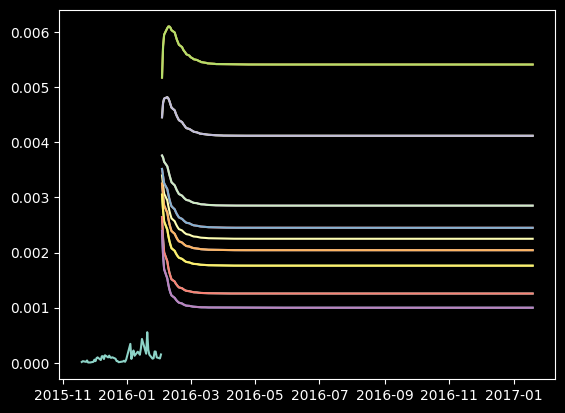

In [5]:
forecast = pd.Series(regarch.volatility_forecast, index=forecast_index)
quantiles = pd.DataFrame(data=regarch.volatility_quantiles, index=regarch.probs, columns=forecast_index)
realised_volatility = underlying.realised_volatility(
	dates=regarch.fitting_dates,
)
realised_volatility.index = pd.to_datetime(regarch.fitting_dates)

plt.plot(realised_volatility[-50:])
plt.plot(forecast)
for prob in regarch.probs:
	plt.plot(quantiles.loc[prob])
	plt.plot(quantiles.loc[round(1 - prob, 3)])
plt.show()

---

In [6]:
from rpy2.robjects.packages import importr, data
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from datetime import datetime

rugarch = importr("rugarch")
pandas2ri.activate()
spyreal = pd.DataFrame(data(rugarch).fetch("spyreal")["spyreal"])  # type: ignore
pandas2ri.activate()
ro.r("data(spyreal)")
spyreal.index = pd.to_datetime(np.array([datetime.utcfromtimestamp(i) for i in np.array(ro.r('attr(spyreal,"index")')).astype(int)]))
spyreal.columns = ["Value", "RVol"]

index = spyreal.index
returns = spyreal.iloc[:, 0]
realised_vol = spyreal.iloc[:, 1]
returns.index = index
realised_vol.index = index

/var/folders/5x/hwwm8kmn4z77258t79_46vfm0000gn/T/ipykernel_20550/646574543.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  spyreal.index = pd.to_datetime(np.array([datetime.utcfromtimestamp(i) for i in np.array(ro.r('attr(spyreal,"index")')).astype(int)]))


In [7]:
with open("/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/time_series/realised_garch.r", "r") as file:
	r(file.read())
include_mean = True
ar_order, ma_order, garch_ar_order, garch_ex_order = 1, 1, 2, 1
window = 100
ro.globalenv["index"] = index[-window:].astype(str)
ro.globalenv["returns"] = returns[-window:]
ro.globalenv["realised_vol"] = realised_vol[-window:]
model = r(f"fit_model({str(include_mean).upper()}, {ar_order}, {ma_order}, {garch_ar_order}, {garch_ex_order}, returns, realised_vol, index)")

horizon = 252
simulations = 100000
ro.globalenv["model"] = model
r(f"forecast <- forecast_model(model, {horizon}, {simulations})")
volatility_forecast = np.array(r("forecast$forecast"))
volatility_distribution = np.array(r("forecast$distribution"))

# print(base.sqrt(rugarch.uncvariance(model)))

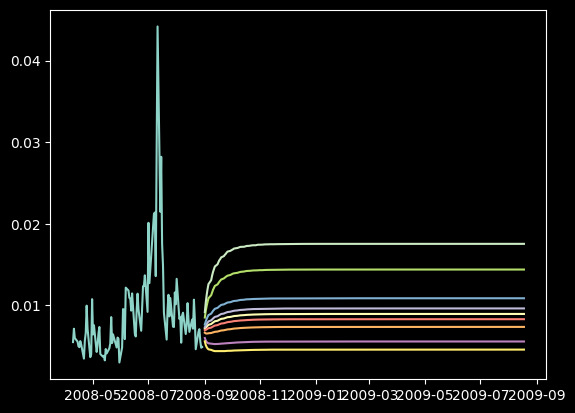

In [8]:
import matplotlib.pyplot as plt

forecast_index = np.busday_offset(spyreal.index.to_numpy().astype("datetime64[D]")[-1], np.arange(1, len(volatility_forecast) + 1))
probs = [0.6, 0.75, 0.95, 0.99]
quantiles = np.quantile(
	pd.DataFrame(volatility_distribution, index=forecast_index),
	[[min(1 - prob, prob), max(1 - prob, prob)] for prob in probs],
	axis=1,
)
quantiles = pd.DataFrame(volatility_distribution, index=forecast_index).quantile(q=np.array([[round(1 - prob, 3), prob] for prob in probs]).ravel(), axis=1)

realised_vol.index = pd.to_datetime(realised_vol.index)
plt.plot(realised_vol[-100:])
plt.plot(pd.Series(volatility_forecast, index=forecast_index))
for prob in probs:
	plt.plot(quantiles.loc[prob])
	plt.plot(quantiles.loc[round(1 - prob, 3)])
plt.show()

In [9]:
%load_ext rpy2.ipython

               logh0      omega    alpha1     alpha2     beta1         xi
rugarch           NA 0.04510044 0.4765638 -0.2027499 0.7050465 -0.1897875
benchmark -0.2892138 0.04124618 0.4506768 -0.1760429 0.7012104 -0.1799949
             delta        eta1       eta2    lambda
rugarch   1.027389 -0.06164514 0.07182943 0.3815489
benchmark 1.037492 -0.06780951 0.07015778 0.3812739
              logh0      omega     alpha1     alpha2      beta1         xi
rugarch          NA 0.01371657 0.02893056 0.04497234 0.03805400 0.03897507
benchmark 0.2787876 0.01551502 0.03802757 0.06335417 0.05597494 0.04361124
               delta        eta1        eta2      lambda
rugarch   0.04025452 0.009665757 0.006210914 0.006620163
benchmark 0.05772650 0.010309694 0.006620828 0.005943210
            filter fit2forecast spec2forecast
2008-07-28 1.10651      1.06558       1.06456
2008-07-29 1.01308      0.97501       0.97150
2008-07-30 0.98851      0.94712       0.94629
2008-07-31 1.08281      1.04033       1.04

In addition: Warning message:
In par(new = TRUE) : calling par(new=TRUE) with no plot


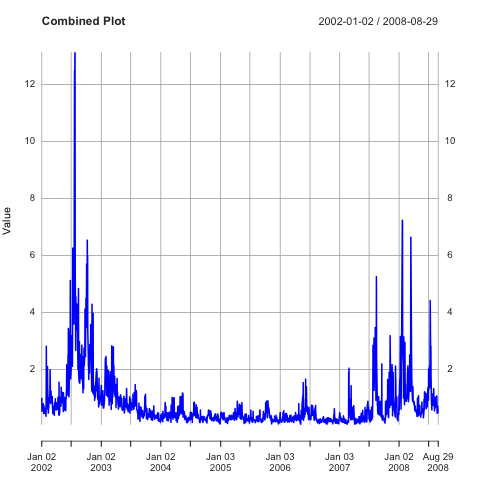

In [46]:
%%R

library(rugarch)
require(xts)
data(spyreal)
spec = ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), variance.model = list(model = 'realGARCH', garchOrder = c(2, 1)))
setbounds(spec)<-list(alpha2=c(-1,1))
fit = ugarchfit(spec, spyreal[, 1] * 100, solver = 'hybrid', realizedVol = spyreal[,2] * 100)

cf = coef(fit)
se = fit@fit$matcoef[, 2]
names(se) = names(cf)
# HHS2012 divide the period into in-(T=1492) and out- of sample, even though they are estimating the model using the entire dataset (T=1659)...no comment.
benchmark.LL = c('logL' = -2388.75, 'pLogL' = -1710.34)
benchmark.pars = c('logh0' = -0.289213754, 'omega' = 0.041246175, 'alpha1' = 0.450676773, 'alpha2' = -0.176042911, 'beta1' = 0.701210369, 'xi' = -0.179994885, 'delta' = 1.037491982, 'eta1' = -0.067809509, 'eta2' = 0.07015778, 'lambda' = sqrt(0.145369801))
benchmark.se = c('logh0' = 0.278787604, 'omega' = 0.015515016, 'alpha1' = 0.038027571, 'alpha2' = 0.06335417, 'beta1' = 0.055974942, 'xi' = 0.043611245, 'delta' = 0.057726499, 'eta1' = 0.010309694, 'eta2' = 0.006620828, 'lambda' = 0.00594321)
# rugarch does not estimate h0, instead uses either mean(residuals^2), else a choice of variance targeting with options
rugarch.LL = c('logL' = sum(-fit@fit$log.likelihoods[1:1492]), 'pLogL' = sum(-fit@fit$partial.log.likelihoods[1:1492]))
rugarch.pars = c('logh0' = NA, 'omega' = cf['omega'], 'alpha1' = cf['alpha1'], 'alpha2' = cf['alpha2'], 'beta1' = cf['beta1'], 'xi' = cf['xi'], 'delta' = cf['delta'], 'eta1' = cf['eta11'], 'eta2' = cf['eta21'], 'lambda' = cf['lambda'])
rugarch.se = c('logh0' = NA, 'omega' = se['omega'], 'alpha1' = se['alpha1'], 'alpha2' = se['alpha2'], 'beta1' = se['beta1'], 'xi' = se['xi'], 'delta' = se['delta'], 'eta1' = se['eta11'], 'eta2' = se['eta21'], 'lambda' = se['lambda'])
names(rugarch.pars) = names(rugarch.se) = c('logh0', 'omega', 'alpha1', 'alpha2', 'beta1', 'xi', 'delta', 'eta1', 'eta2', 'lambda')
parsdf = cbind(benchmark.pars, rugarch.pars, benchmark.pars - rugarch.pars)
sedf = cbind(benchmark.se, rugarch.se, benchmark.se - rugarch.se)
LRE.vars = -log(abs(rugarch.pars - benchmark.pars)/abs(benchmark.pars), base = 10)
LRE.se = -log(abs(rugarch.se - benchmark.se)/abs(benchmark.se), base = 10)
test = cbind(LRE.vars, LRE.se)
tmp1 = t(cbind(rugarch = rugarch.pars, benchmark = benchmark.pars))
tmp2 = t(cbind(rugarch = rugarch.se, benchmark = benchmark.se))
(round(t(cbind(rugarch.pars, benchmark.pars)),4))
print(tmp1)
print(tmp2)
# print the results:
# parameters:
#             logh0  omega alpha1  alpha2  beta1      xi delta    eta1   eta2  lambda
# rugarch        NA 0.0451 0.4766 -0.2027 0.7050 -0.1898 1.027 -0.0616 0.0718  0.3815
# benchmark -0.2892 0.0412 0.4507 -0.1760 0.7012 -0.1800 1.038 -0.0678 0.0702  0.3813
#
# standard errors:
#            logh0  omega alpha1 alpha2  beta1     xi  delta   eta1   eta2 lambda
# rugarch       NA 0.0137 0.0289 0.0450 0.0381 0.0390 0.0403 0.0097 0.0062 0.0066
# benchmark 0.2788 0.0155 0.0380 0.0634 0.0560 0.0436 0.0577 0.0103 0.0066 0.0059
#
# Log Relative Error Test:
#          logh0  omega alpha1 alpha2  beta1     xi delta  eta1  eta2 lambda
# LRE.vars    NA 1.0293 1.2408 0.8191 2.2627 1.2640 2.012 1.041 1.623 3.1413
# LRE.se      NA 0.9355 0.6212 0.5374 0.4947 0.9733 0.519 1.204 1.208 0.9435

fit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 25, solver = 'hybrid', realizedVol = spyreal[, 2] * 100)
specf = spec
setfixed(specf) <- as.list(coef(fit))
filt = ugarchfilter(specf, data = spyreal[, 1] * 100, n.old = nrow(spyreal) - 25, realizedVol = spyreal[, 2] * 100)
forc1 = ugarchforecast(fit, n.ahead = 1, n.roll = 25)
# forecast from spec
forc2 = ugarchforecast(specf, n.ahead = 1, n.roll = 25, data = spyreal[, 1] * 100, out.sample = 25, realizedVol = spyreal[, 2] * 100)
filts = tail(sigma(filt), 25)
colnames(filts) = 'filter'
forcs1 = xts(sigma(forc1)[1, ], move(as.Date(names(sigma(forc1)[1, ])), by = 1))
forcs2 = xts(sigma(forc2)[1, ], move(as.Date(names(sigma(forc2)[1, ])), by = 1))
colnames(forcs1) = 'fit2forecast'
colnames(forcs2) = 'spec2forecast'
ftest = cbind(filts, forcs1, forcs2)
# last forecast is completely out of sample, so not available from the
# filter method (which filters given T-1)
print(round(ftest, 5))
##            filter fit2forecast spec2forecast
## 2008-07-28 1.1065       1.1065        1.1065
## 2008-07-29 1.0131       1.0131        1.0131
## 2008-07-30 0.9885       0.9885        0.9885
## 2008-07-31 1.0828       1.0828        1.0828
## 2008-08-01 1.0685       1.0685        1.0685
## 2008-08-04 1.1434       1.1434        1.1434
## 2008-08-05 1.0460       1.0460        1.0460
## 2008-08-06 1.0351       1.0351        1.0351
## 2008-08-07 0.9206       0.9206        0.9206
## 2008-08-08 0.9933       0.9933        0.9933
## 2008-08-11 1.0083       1.0083        1.0083
## 2008-08-12 0.9368       0.9368        0.9368
## 2008-08-13 0.9564       0.9564        0.9564
## 2008-08-14 1.0243       1.0243        1.0243
## 2008-08-15 0.9903       0.9903        0.9903
## 2008-08-18 0.9432       0.9432        0.9432
## 2008-08-19 0.9751       0.9751        0.9751
## 2008-08-20 0.9453       0.9453        0.9453
## 2008-08-21 1.0326       1.0326        1.0326
## 2008-08-22 0.9930       0.9930        0.9930
## 2008-08-25 0.8638       0.8638        0.8638
## 2008-08-26 0.9082       0.9082        0.9082
## 2008-08-27 0.9154       0.9154        0.9154
## 2008-08-28 0.8658       0.8658        0.8658
## 2008-08-29 0.8235       0.8235        0.8235
## 2008-09-01     NA       0.8103        0.8103

# ni = newsimpact(fit, z = seq(-2, 2, length.out = 100))
# plot(ni$zx, (ni$zy), ylab = ni$yexpr, xlab = ni$xexpr, type = 'l', main = 'News Impact realGARCH')
# abline(v = 0)
# abline(h = 0)
# grid()

set.seed(55)
# forc3 = ugarchforecast(fit, n.ahead = 400, n.sim = 5000)
# plot <- plot(sigma(forc3), type = 'l', main = 'realGARCH long-run forecast')
# abline(h = sqrt(uncvariance(fit)), col = 2)
# legend('topright', c('long-run forecast', 'unconditional value'), col = 1:2, lty = c(1, 1), bty = 'n')

set.seed(55)
forc4 = ugarchforecast(fit, n.ahead = 25, n.sim = 10000)
# dim(forc4@forecast$sigmaDF)
sigmaDF = forc4@forecast$sigmaDF
meansig = sqrt(exp(rowMeans(log(sigmaDF[, , 1]^2))))
# boxplot(t(sigmaDF[, , 1]), main = '25-ahead volatility forecast (realGARCH)', col = 'orange')
# points(as.numeric(meansig), col = 'green')
# note that for the 1-ahead there is no uncertainty (unless we were doing this Bayes-style so that parameter uncertainty would have an impact).

library(parallel)
cl = makePSOCKcluster(5)
spec1 = ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), variance.model = list(model = 'realGARCH', garchOrder = c(1, 1)))
spec2 = ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), variance.model = list(model = 'eGARCH', garchOrder = c(1, 1)))
roll1 = ugarchroll(spec1, spyreal[, 1] * 100, forecast.length = 500, solver = 'hybrid', refit.every = 25, refit.window = 'recursive', realizedVol = spyreal[, 2] * 100, cluster = cl)
roll2 = ugarchroll(spec2, spyreal[, 1] * 100, forecast.length = 500, refit.every = 25, refit.window = 'recursive', cluster = cl)
report(roll1)
## VaR Backtest Report
## ===========================================
## Model:           realGARCH-norm
## Backtest Length: 500
## Data:
##
## ==========================================
## alpha:               1%
## Expected Exceed:     5
## Actual VaR Exceed:   10
## Actual %:            2%
##
## Unconditional Coverage (Kupiec)
## Null-Hypothesis: Correct Exceedances
## LR.uc Statistic: 3.914
## LR.uc Critical:  3.841
## LR.uc p-value:   0.048
## Reject Null:     YES
##
## Conditional Coverage (Christoffersen)
## Null-Hypothesis: Correct Exceedances and
##                  Independence of Failures
## LR.cc Statistic: 4.323
## LR.cc Critical:  5.991
## LR.cc p-value:   0.115
## Reject Null:     NO
##
##
report(roll2)
## VaR Backtest Report
## ===========================================
## Model:           eGARCH-norm
## Backtest Length: 500
## Data:
##
## ==========================================
## alpha:               1%
## Expected Exceed:     5
## Actual VaR Exceed:   16
## Actual %:            3.2%
##
## Unconditional Coverage (Kupiec)
## Null-Hypothesis: Correct Exceedances
## LR.uc Statistic: 15.467
## LR.uc Critical:  3.841
## LR.uc p-value:   0
## Reject Null:     YES
##
## Conditional Coverage (Christoffersen)
## Null-Hypothesis: Correct Exceedances and
##                  Independence of Failures
## LR.cc Statistic: 16.527
## LR.cc Critical:  5.991
## LR.cc p-value:   0
## Reject Null:     YES
##
##
plot(as.xts(as.data.frame(roll1)[, 'Sigma', drop = FALSE]), main = 'realGARCH vs eGARCH\n(out-of-sample volatility forecast)',  auto.grid = FALSE, minor.ticks = FALSE)
lines(spyreal[, 2] * 100, col = 'blue', ylab = "Value", xlab = "Index", main = "Combined Plot")
# legend('topleft', c('realGARCH', 'eGARCH'), col = 1:2, lty = c(1, 1), bty = 'n')
# grid()


In [19]:
%%R

library(rugarch)
require(xts)
data(spyreal)
spec = ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), variance.model = list(model = 'realGARCH', garchOrder = c(2, 1)))
setbounds(spec)<-list(alpha2=c(-1,1))
fit = ugarchfit(spec, spyreal[, 1] * 100, solver = 'hybrid', realizedVol = spyreal[,2] * 100)

cf = coef(fit)
se = fit@fit$matcoef[, 2]
names(se) = names(cf)
# HHS2012 divide the period into in-(T=1492) and out- of sample, even though they are estimating the model using the entire dataset (T=1659)...no comment.
benchmark.LL = c('logL' = -2388.75, 'pLogL' = -1710.34)
benchmark.pars = c('logh0' = -0.289213754, 'omega' = 0.041246175, 'alpha1' = 0.450676773, 'alpha2' = -0.176042911, 'beta1' = 0.701210369, 'xi' = -0.179994885, 'delta' = 1.037491982, 'eta1' = -0.067809509, 'eta2' = 0.07015778, 'lambda' = sqrt(0.145369801))
benchmark.se = c('logh0' = 0.278787604, 'omega' = 0.015515016, 'alpha1' = 0.038027571, 'alpha2' = 0.06335417, 'beta1' = 0.055974942, 'xi' = 0.043611245, 'delta' = 0.057726499, 'eta1' = 0.010309694, 'eta2' = 0.006620828, 'lambda' = 0.00594321)
# rugarch does not estimate h0, instead uses either mean(residuals^2), else a choice of variance targeting with options
rugarch.LL = c('logL' = sum(-fit@fit$log.likelihoods[1:1492]), 'pLogL' = sum(-fit@fit$partial.log.likelihoods[1:1492]))
rugarch.pars = c('logh0' = NA, 'omega' = cf['omega'], 'alpha1' = cf['alpha1'], 'alpha2' = cf['alpha2'], 'beta1' = cf['beta1'], 'xi' = cf['xi'], 'delta' = cf['delta'], 'eta1' = cf['eta11'], 'eta2' = cf['eta21'], 'lambda' = cf['lambda'])
rugarch.se = c('logh0' = NA, 'omega' = se['omega'], 'alpha1' = se['alpha1'], 'alpha2' = se['alpha2'], 'beta1' = se['beta1'], 'xi' = se['xi'], 'delta' = se['delta'], 'eta1' = se['eta11'], 'eta2' = se['eta21'], 'lambda' = se['lambda'])
names(rugarch.pars) = names(rugarch.se) = c('logh0', 'omega', 'alpha1', 'alpha2', 'beta1', 'xi', 'delta', 'eta1', 'eta2', 'lambda')
parsdf = cbind(benchmark.pars, rugarch.pars, benchmark.pars - rugarch.pars)
sedf = cbind(benchmark.se, rugarch.se, benchmark.se - rugarch.se)
LRE.vars = -log(abs(rugarch.pars - benchmark.pars)/abs(benchmark.pars), base = 10)
LRE.se = -log(abs(rugarch.se - benchmark.se)/abs(benchmark.se), base = 10)
test = cbind(LRE.vars, LRE.se)
tmp1 = t(cbind(rugarch = rugarch.pars, benchmark = benchmark.pars))
tmp2 = t(cbind(rugarch = rugarch.se, benchmark = benchmark.se))
# print the results:
## parameters:
##             logh0  omega alpha1  alpha2  beta1      xi delta    eta1   eta2  lambda
## rugarch        NA 0.0451 0.4766 -0.2027 0.7050 -0.1898 1.027 -0.0616 0.0718  0.3815
## benchmark -0.2892 0.0412 0.4507 -0.1760 0.7012 -0.1800 1.038 -0.0678 0.0702  0.3813
##
## standard errors:
##            logh0  omega alpha1 alpha2  beta1     xi  delta   eta1   eta2 lambda
## rugarch       NA 0.0137 0.0289 0.0450 0.0381 0.0390 0.0403 0.0097 0.0062 0.0066
## benchmark 0.2788 0.0155 0.0380 0.0634 0.0560 0.0436 0.0577 0.0103 0.0066 0.0059
##
## Log Relative Error Test:
##          logh0  omega alpha1 alpha2  beta1     xi delta  eta1  eta2 lambda
## LRE.vars    NA 1.0293 1.2408 0.8191 2.2627 1.2640 2.012 1.041 1.623 3.1413
## LRE.se      NA 0.9355 0.6212 0.5374 0.4947 0.9733 0.519 1.204 1.208 0.9435

fit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 25, solver = 'hybrid', realizedVol = spyreal[, 2] * 100)
specf = spec
setfixed(specf) <- as.list(coef(fit))
filt = ugarchfilter(specf, data = spyreal[, 1] * 100, n.old = nrow(spyreal) - 25, realizedVol = spyreal[, 2] * 100)
forc1 = ugarchforecast(fit, n.ahead = 1, n.roll = 25)
# forecast from spec
forc2 = ugarchforecast(specf, n.ahead = 1, n.roll = 25, data = spyreal[, 1] * 100, out.sample = 25, realizedVol = spyreal[, 2] * 100)
filts = tail(sigma(filt), 25)
colnames(filts) = 'filter'
forcs1 = xts(sigma(forc1)[1, ], move(as.Date(names(sigma(forc1)[1, ])), by = 1))
forcs2 = xts(sigma(forc2)[1, ], move(as.Date(names(sigma(forc2)[1, ])), by = 1))
colnames(forcs1) = 'fit2forecast'
colnames(forcs2) = 'spec2forecast'
ftest = cbind(filts, forcs1, forcs2)
# last forecast is completely out of sample, so not available from the
# filter method (which filters given T-1)
# print(round(ftest, 5))
##            filter fit2forecast spec2forecast
## 2008-07-28 1.1065       1.1065        1.1065
## 2008-07-29 1.0131       1.0131        1.0131
## 2008-07-30 0.9885       0.9885        0.9885
## 2008-07-31 1.0828       1.0828        1.0828
## 2008-08-01 1.0685       1.0685        1.0685
## 2008-08-04 1.1434       1.1434        1.1434
## 2008-08-05 1.0460       1.0460        1.0460
## 2008-08-06 1.0351       1.0351        1.0351
## 2008-08-07 0.9206       0.9206        0.9206
## 2008-08-08 0.9933       0.9933        0.9933
## 2008-08-11 1.0083       1.0083        1.0083
## 2008-08-12 0.9368       0.9368        0.9368
## 2008-08-13 0.9564       0.9564        0.9564
## 2008-08-14 1.0243       1.0243        1.0243
## 2008-08-15 0.9903       0.9903        0.9903
## 2008-08-18 0.9432       0.9432        0.9432
## 2008-08-19 0.9751       0.9751        0.9751
## 2008-08-20 0.9453       0.9453        0.9453
## 2008-08-21 1.0326       1.0326        1.0326
## 2008-08-22 0.9930       0.9930        0.9930
## 2008-08-25 0.8638       0.8638        0.8638
## 2008-08-26 0.9082       0.9082        0.9082
## 2008-08-27 0.9154       0.9154        0.9154
## 2008-08-28 0.8658       0.8658        0.8658
## 2008-08-29 0.8235       0.8235        0.8235
## 2008-09-01     NA       0.8103        0.8103

# set.seed(55)
# forc3 = ugarchforecast(fit, n.ahead = 400, n.sim = 5000)
# plot(sigma(forc3), type = 'l', main = 'realGARCH long-run forecast')
# abline(h = sqrt(uncvariance(fit)), col = 2)
# legend('topright', c('long-run forecast', 'unconditional value'), col = 1:2, lty = c(1, 1), bty = 'n')
fit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 1, solver = 'hybrid', realizedVol = spyreal[, 2] * 100)
# forc1 = ugarchroll(spec, spyreal[, 1] * 100, n.ahead = 1, refit.every = 5, forecast.length=100, realizedVol = spyreal[, 2] * 100)
# # plot((forc1), type = 'l', main = 'realGARCH long-run forecast')
# # abline(h = sqrt(uncvariance(fit)), col = 2)
# plot(forc1@forecast$density$Sigma, type='l')

forc = ugarchforecast(fit, n.ahead=250, n.sim = 5000)
# plot(sigma(forc), type='l')
plot(spyreal[, 2] * 100, type = 'l', col = 'blue', ylab = "Value", xlab = "Index", main = "Combined Plot")
lines(sigma(forc), col = 'red')


Error in plot.xy(xy.coords(x, y), type = type, ...) : 
  plot.new has not been called yet


RInterpreterError: Failed to parse and evaluate line '\nlibrary(rugarch)\nrequire(xts)\ndata(spyreal)\nspec = ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), variance.model = list(model = \'realGARCH\', garchOrder = c(2, 1)))\nsetbounds(spec)<-list(alpha2=c(-1,1))\nfit = ugarchfit(spec, spyreal[, 1] * 100, solver = \'hybrid\', realizedVol = spyreal[,2] * 100)\n\ncf = coef(fit)\nse = fit@fit$matcoef[, 2]\nnames(se) = names(cf)\n# HHS2012 divide the period into in-(T=1492) and out- of sample, even though they are estimating the model using the entire dataset (T=1659)...no comment.\nbenchmark.LL = c(\'logL\' = -2388.75, \'pLogL\' = -1710.34)\nbenchmark.pars = c(\'logh0\' = -0.289213754, \'omega\' = 0.041246175, \'alpha1\' = 0.450676773, \'alpha2\' = -0.176042911, \'beta1\' = 0.701210369, \'xi\' = -0.179994885, \'delta\' = 1.037491982, \'eta1\' = -0.067809509, \'eta2\' = 0.07015778, \'lambda\' = sqrt(0.145369801))\nbenchmark.se = c(\'logh0\' = 0.278787604, \'omega\' = 0.015515016, \'alpha1\' = 0.038027571, \'alpha2\' = 0.06335417, \'beta1\' = 0.055974942, \'xi\' = 0.043611245, \'delta\' = 0.057726499, \'eta1\' = 0.010309694, \'eta2\' = 0.006620828, \'lambda\' = 0.00594321)\n# rugarch does not estimate h0, instead uses either mean(residuals^2), else a choice of variance targeting with options\nrugarch.LL = c(\'logL\' = sum(-fit@fit$log.likelihoods[1:1492]), \'pLogL\' = sum(-fit@fit$partial.log.likelihoods[1:1492]))\nrugarch.pars = c(\'logh0\' = NA, \'omega\' = cf[\'omega\'], \'alpha1\' = cf[\'alpha1\'], \'alpha2\' = cf[\'alpha2\'], \'beta1\' = cf[\'beta1\'], \'xi\' = cf[\'xi\'], \'delta\' = cf[\'delta\'], \'eta1\' = cf[\'eta11\'], \'eta2\' = cf[\'eta21\'], \'lambda\' = cf[\'lambda\'])\nrugarch.se = c(\'logh0\' = NA, \'omega\' = se[\'omega\'], \'alpha1\' = se[\'alpha1\'], \'alpha2\' = se[\'alpha2\'], \'beta1\' = se[\'beta1\'], \'xi\' = se[\'xi\'], \'delta\' = se[\'delta\'], \'eta1\' = se[\'eta11\'], \'eta2\' = se[\'eta21\'], \'lambda\' = se[\'lambda\'])\nnames(rugarch.pars) = names(rugarch.se) = c(\'logh0\', \'omega\', \'alpha1\', \'alpha2\', \'beta1\', \'xi\', \'delta\', \'eta1\', \'eta2\', \'lambda\')\nparsdf = cbind(benchmark.pars, rugarch.pars, benchmark.pars - rugarch.pars)\nsedf = cbind(benchmark.se, rugarch.se, benchmark.se - rugarch.se)\nLRE.vars = -log(abs(rugarch.pars - benchmark.pars)/abs(benchmark.pars), base = 10)\nLRE.se = -log(abs(rugarch.se - benchmark.se)/abs(benchmark.se), base = 10)\ntest = cbind(LRE.vars, LRE.se)\ntmp1 = t(cbind(rugarch = rugarch.pars, benchmark = benchmark.pars))\ntmp2 = t(cbind(rugarch = rugarch.se, benchmark = benchmark.se))\n# print the results:\n## parameters:\n##             logh0  omega alpha1  alpha2  beta1      xi delta    eta1   eta2  lambda\n## rugarch        NA 0.0451 0.4766 -0.2027 0.7050 -0.1898 1.027 -0.0616 0.0718  0.3815\n## benchmark -0.2892 0.0412 0.4507 -0.1760 0.7012 -0.1800 1.038 -0.0678 0.0702  0.3813\n##\n## standard errors:\n##            logh0  omega alpha1 alpha2  beta1     xi  delta   eta1   eta2 lambda\n## rugarch       NA 0.0137 0.0289 0.0450 0.0381 0.0390 0.0403 0.0097 0.0062 0.0066\n## benchmark 0.2788 0.0155 0.0380 0.0634 0.0560 0.0436 0.0577 0.0103 0.0066 0.0059\n##\n## Log Relative Error Test:\n##          logh0  omega alpha1 alpha2  beta1     xi delta  eta1  eta2 lambda\n## LRE.vars    NA 1.0293 1.2408 0.8191 2.2627 1.2640 2.012 1.041 1.623 3.1413\n## LRE.se      NA 0.9355 0.6212 0.5374 0.4947 0.9733 0.519 1.204 1.208 0.9435\n\nfit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 25, solver = \'hybrid\', realizedVol = spyreal[, 2] * 100)\nspecf = spec\nsetfixed(specf) <- as.list(coef(fit))\nfilt = ugarchfilter(specf, data = spyreal[, 1] * 100, n.old = nrow(spyreal) - 25, realizedVol = spyreal[, 2] * 100)\nforc1 = ugarchforecast(fit, n.ahead = 1, n.roll = 25)\n# forecast from spec\nforc2 = ugarchforecast(specf, n.ahead = 1, n.roll = 25, data = spyreal[, 1] * 100, out.sample = 25, realizedVol = spyreal[, 2] * 100)\nfilts = tail(sigma(filt), 25)\ncolnames(filts) = \'filter\'\nforcs1 = xts(sigma(forc1)[1, ], move(as.Date(names(sigma(forc1)[1, ])), by = 1))\nforcs2 = xts(sigma(forc2)[1, ], move(as.Date(names(sigma(forc2)[1, ])), by = 1))\ncolnames(forcs1) = \'fit2forecast\'\ncolnames(forcs2) = \'spec2forecast\'\nftest = cbind(filts, forcs1, forcs2)\n# last forecast is completely out of sample, so not available from the\n# filter method (which filters given T-1)\n# print(round(ftest, 5))\n##            filter fit2forecast spec2forecast\n## 2008-07-28 1.1065       1.1065        1.1065\n## 2008-07-29 1.0131       1.0131        1.0131\n## 2008-07-30 0.9885       0.9885        0.9885\n## 2008-07-31 1.0828       1.0828        1.0828\n## 2008-08-01 1.0685       1.0685        1.0685\n## 2008-08-04 1.1434       1.1434        1.1434\n## 2008-08-05 1.0460       1.0460        1.0460\n## 2008-08-06 1.0351       1.0351        1.0351\n## 2008-08-07 0.9206       0.9206        0.9206\n## 2008-08-08 0.9933       0.9933        0.9933\n## 2008-08-11 1.0083       1.0083        1.0083\n## 2008-08-12 0.9368       0.9368        0.9368\n## 2008-08-13 0.9564       0.9564        0.9564\n## 2008-08-14 1.0243       1.0243        1.0243\n## 2008-08-15 0.9903       0.9903        0.9903\n## 2008-08-18 0.9432       0.9432        0.9432\n## 2008-08-19 0.9751       0.9751        0.9751\n## 2008-08-20 0.9453       0.9453        0.9453\n## 2008-08-21 1.0326       1.0326        1.0326\n## 2008-08-22 0.9930       0.9930        0.9930\n## 2008-08-25 0.8638       0.8638        0.8638\n## 2008-08-26 0.9082       0.9082        0.9082\n## 2008-08-27 0.9154       0.9154        0.9154\n## 2008-08-28 0.8658       0.8658        0.8658\n## 2008-08-29 0.8235       0.8235        0.8235\n## 2008-09-01     NA       0.8103        0.8103\n\n# set.seed(55)\n# forc3 = ugarchforecast(fit, n.ahead = 400, n.sim = 5000)\n# plot(sigma(forc3), type = \'l\', main = \'realGARCH long-run forecast\')\n# abline(h = sqrt(uncvariance(fit)), col = 2)\n# legend(\'topright\', c(\'long-run forecast\', \'unconditional value\'), col = 1:2, lty = c(1, 1), bty = \'n\')\nfit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 1, solver = \'hybrid\', realizedVol = spyreal[, 2] * 100)\n# forc1 = ugarchroll(spec, spyreal[, 1] * 100, n.ahead = 1, refit.every = 5, forecast.length=100, realizedVol = spyreal[, 2] * 100)\n# # plot((forc1), type = \'l\', main = \'realGARCH long-run forecast\')\n# # abline(h = sqrt(uncvariance(fit)), col = 2)\n# plot(forc1@forecast$density$Sigma, type=\'l\')\n\nforc = ugarchforecast(fit, n.ahead=250, n.sim = 5000)\n# plot(sigma(forc), type=\'l\')\nplot(spyreal[, 2] * 100, type = \'l\', col = \'blue\', ylab = "Value", xlab = "Index", main = "Combined Plot")\nlines(sigma(forc), col = \'red\')\n'.
R error message: 'Error in plot.xy(xy.coords(x, y), type = type, ...) : \n  plot.new has not been called yet'